# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [ ]:
# импортируем нужные библиотеки и методы
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, precision_score,recall_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from collections import Counter
import seaborn as sns
import pandas_profiling
from sklearn.metrics import plot_roc_curve,plot_confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# скрываем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# фиксируем ГПЧ
np.random.seed(7)

## Откройте и изучите файл

In [ ]:
# читаем файл с данными
df = pd.read_csv('/datasets/users_behavior.csv')

Екатерина

In [ ]:
# Функция для ознакомления с данными
def pre_view(data,n_row=4,head=True, info=True,columns=True,shape=True,isna=True,duplicated=True):
    if head:
        print(f'First {n_row} row(s) in the head of data')
        display(data.head(n_row))
        print('-'*30)
    if info:
        print('Data Information:')
        display(data.info())
        print('-'*30)
    if columns:
        print('Data columns:')
        display(data.columns)
        print('-'*30)
    if shape:
        print('Data shape:')
        display(data.shape)
        print('-'*30)
    if isna:
        print('Data isna by row mean:')
        display(data.isna().mean())
        print('-'*30)
    if duplicated:
        print('Data clear duplicates sum:')
        display(data.isna().mean())
        print('-'*30)



In [ ]:
pre_view(df)

First 4 row(s) in the head of data


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1


------------------------------
Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

------------------------------
Data columns:


Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

------------------------------
Data shape:


(3214, 5)

------------------------------
Data isna by row mean:


calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

------------------------------
Data clear duplicates sum:


calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

------------------------------


In [ ]:
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/19 [00:00<?, ?it/s]

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

## Разбейте данные на выборки

In [ ]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
# отбираем целевые и тренировочные списки
features = df.drop('is_ultra',axis=1)
target = df['is_ultra']


In [ ]:
rs=7

In [ ]:
# разбиваем данные на тренировочкую, тестовую и валидационную выборки в соотношении 3:1:1
features_train,features_test_valid,target_train, target_test_valid = train_test_split(features,target,train_size=0.60,random_state=rs,stratify=target)
features_test,features_valid,target_test,target_valid = train_test_split(features_test_valid,target_test_valid,test_size=0.5,random_state=rs,stratify=target_test_valid)

In [ ]:
target_train.name = 'target_train'
target_test.name = 'target_test'
target_valid.name = 'target_valid'


In [ ]:
# проверка на дисбаланс
disbalance_dct = {}
def disbalance_check(Y):

    major =str(sorted(Counter(Y).items())[0][0])+': '+str(sorted(Counter(Y).items())[0][1])
    minor = str(sorted(Counter(Y).items())[1][0])+': '+str(sorted(Counter(Y).items())[1][1])
    ratio =  sorted(Counter(Y).items())[0][1] / sorted(Counter(Y).items())[1][1]
    print(f'В нашем наборе данных {Y.name} количество записей главного класса равно {major}, а второстепенного {minor}\nОтношение главного к второстепенному равно {ratio}')
    if ratio > 1:
        print('Присутствует дисбаланс классов в данных')
    disbalance_dct[Y.name] = ratio











In [ ]:
targets_lst = [target_train,target_test,target_valid]

In [ ]:
# для каждой выборки находим коэфф дисбаланса классов и
# значения главного и второстепенного
list(map(disbalance_check,targets_lst))

В нашем наборе данных target_train количество записей главного класса равно 0: 1337, а второстепенного 1: 591
Отношение главного к второстепенному равно 2.2622673434856178
Присутствует дисбаланс классов в данных
В нашем наборе данных target_test количество записей главного класса равно 0: 446, а второстепенного 1: 197
Отношение главного к второстепенному равно 2.263959390862944
Присутствует дисбаланс классов в данных
В нашем наборе данных target_valid количество записей главного класса равно 0: 446, а второстепенного 1: 197
Отношение главного к второстепенному равно 2.263959390862944
Присутствует дисбаланс классов в данных


[None, None, None]

In [ ]:
disbalance_dct

{'target_train': 2.2622673434856178,
 'target_test': 2.263959390862944,
 'target_valid': 2.263959390862944}

**Вывод:**

Имеется дисбаланс классов перекос в сторону 0.

In [ ]:
# смотрим на выборки
features_train.shape

(1928, 4)

In [ ]:
features_test_valid.shape

(1286, 4)

In [ ]:
target_train.shape

(1928,)

In [ ]:
target_test_valid.shape

(1286,)

<AxesSubplot:>

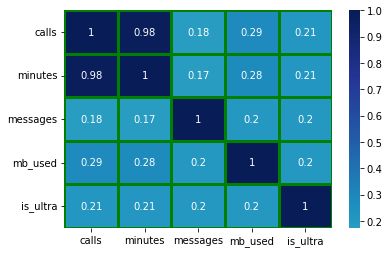

In [ ]:
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu",center=0,linewidth=3,linecolor='green')

## Исследуйте модели

In [ ]:
# создаем переменные для:
# лучшего тестового результата для accuracy
best_score_test = 0
# лучшего валидационного результата для accuracy
best_score_valid = 0
# лучшего тестового результата для balanced accuracy
best_balanced_accuracy_score_tst = 0
# лучшего валидационного результата для balanced accuracy
best_balanced_accuracy_score_vld = 0
# словарь для занесения туда всех комбианций
# параметров в модели и значения accuracy
# для тестовой и валидационной выборки
dct = {}
# список для значений результатов тестов
# на тестовой и валидационной выборках
# для accuracy и balanced accuracy
score_lst =[0,0,0,0]
# "решатели" для поиска оптимального гиперпараметра
solvers = ['liblinear','newton-cg','lbfgs']
# цикл по "решателям"
for solver in solvers:
#     цикл по количеству итераций
    for iter_ in range(100,1101,50):
#       задаем гиперпараметры для модели
        forest_clf = LogisticRegression(penalty='l2',max_iter=iter_,solver=solver,random_state=rs)
#     обучаем
        forest_clf.fit(features_train,target_train)
#     предсказываем
        predictions_test= forest_clf.predict(features_test)
        predictions_valid = forest_clf.predict(features_valid)
#         находим значение accuracy для тестовой и валидационной выборок
        accuracy_test= accuracy_score(target_test,predictions_test)
        accuracy_valid = accuracy_score(target_valid,predictions_valid)
#        находим значение balanced accuracy для тестовой и валидационной выборок
        balanced_accuracy_score_tst = balanced_accuracy_score(target_test,predictions_test)
        balanced_accuracy_score_vld = balanced_accuracy_score(target_valid,predictions_valid)
#        фиксирурем лучшие значения нужных нам метрик для лучшей модели
# добавляем в список score_lst лучшие значения тестовых и валидационных вборок для
# accuracy и balanced accuracy соответственно
        if best_score_test < accuracy_test:
            best_score_test = accuracy_test
            score_lst[0] = f'Лучший результат accuracy на тестовой выборке при параметрах: penalty = l2, iter = {iter_} and solver={solver} равен {accuracy_test} а результат на валидационной равен {accuracy_valid} и balanced_accuracy равен на валидационной и тестовой соответственно {balanced_accuracy_score_vld} и {balanced_accuracy_score_tst}'
        if best_score_valid < accuracy_valid:
            best_score_valid = accuracy_valid
            score_lst[1] = f'Лучший результат accuracy на валидационной выборке при параметрах: penalty = l2, iter = {iter_} and solver={solver} равен {accuracy_valid} а результат на тестовой равен {accuracy_test} и balanced_accuracy равен на валидационной и тестовой соответственно {balanced_accuracy_score_vld} и {balanced_accuracy_score_tst}'
        if best_balanced_accuracy_score_tst < balanced_accuracy_score_tst:
            best_balanced_accuracy_score_tst = balanced_accuracy_score_tst
            score_lst[2] = f'Лучший результат balanced_accuracy на тестовой выборке при параметрах: penalty = l2, iter = {iter_} and solver={solver} равен {best_balanced_accuracy_score_tst} а результат на валидационной равен {balanced_accuracy_score_vld} и accuracy равен на валидационной и тестовой соответственно {accuracy_valid} и {accuracy_test}'
        if best_balanced_accuracy_score_vld < balanced_accuracy_score_vld:
            best_balanced_accuracy_score_vld = balanced_accuracy_score_vld
            score_lst[3] = f'Лучший результат balanced_accuracy на валидационной выборке при параметрах: penalty = l2, iter = {iter_} and solver={solver} равен {best_balanced_accuracy_score_vld} а результат на тестовой равен {balanced_accuracy_score_tst} и accuracy равен на валидационной и тестовой соответственно {accuracy_valid} и {accuracy_test}'
#         формируем словарь со сзначениями для accuracy на тестовой и валидационной выборках
        dct[f'penalty = l2, iter = {iter_} and solver={solver}'] = str(accuracy_test) + ' ' + str(accuracy_valid)
# выводим лучшие результаты метрик для моделей
print(f'Лучший результат по accuracy на тестовой выборке равен {best_score_test}', f'Лучший результат по accuracy на валидационной выборке равен {best_score_valid}\n',sep='\n',end='-'*100)
print(f'\nЛучший результат по balanced_accuracy на тестовой выборке равен {best_balanced_accuracy_score_tst}', f'Лучший результат по balanced_accuracy на валидационной выборке равен {best_balanced_accuracy_score_vld}',sep='\n')

Лучший результат по accuracy на тестовой выборке равен 0.7433903576982893
Лучший результат по accuracy на валидационной выборке равен 0.7729393468118196
----------------------------------------------------------------------------------------------------
Лучший результат по balanced_accuracy на тестовой выборке равен 0.5939712276069291
Лучший результат по balanced_accuracy на валидационной выборке равен 0.6407775830279301


In [ ]:
score_lst

['Лучший результат accuracy на тестовой выборке при параметрах: penalty = l2, iter = 100 and solver=newton-cg равен 0.7433903576982893 а результат на валидационной равен 0.7729393468118196 и balanced_accuracy равен на валидационной и тестовой соответственно 0.6407775830279301 и 0.5939712276069291',
 'Лучший результат accuracy на валидационной выборке при параметрах: penalty = l2, iter = 100 and solver=newton-cg равен 0.7729393468118196 а результат на тестовой равен 0.7433903576982893 и balanced_accuracy равен на валидационной и тестовой соответственно 0.6407775830279301 и 0.5939712276069291',
 'Лучший результат balanced_accuracy на тестовой выборке при параметрах: penalty = l2, iter = 100 and solver=newton-cg равен 0.5939712276069291 а результат на валидационной равен 0.6407775830279301 и accuracy равен на валидационной и тестовой соответственно 0.7729393468118196 и 0.7433903576982893',
 'Лучший результат balanced_accuracy на валидационной выборке при параметрах: penalty = l2, iter = 1

In [ ]:
disbalance_dct

{'target_train': 2.2622673434856178,
 'target_test': 2.263959390862944,
 'target_valid': 2.263959390862944}

In [ ]:
score_lst

['Лучший результат accuracy на тестовой выборке при параметрах: penalty = l2, iter = 100 and solver=newton-cg равен 0.7433903576982893 а результат на валидационной равен 0.7729393468118196 и balanced_accuracy равен на валидационной и тестовой соответственно 0.6407775830279301 и 0.5939712276069291',
 'Лучший результат accuracy на валидационной выборке при параметрах: penalty = l2, iter = 100 and solver=newton-cg равен 0.7729393468118196 а результат на тестовой равен 0.7433903576982893 и balanced_accuracy равен на валидационной и тестовой соответственно 0.6407775830279301 и 0.5939712276069291',
 'Лучший результат balanced_accuracy на тестовой выборке при параметрах: penalty = l2, iter = 100 and solver=newton-cg равен 0.5939712276069291 а результат на валидационной равен 0.6407775830279301 и accuracy равен на валидационной и тестовой соответственно 0.7729393468118196 и 0.7433903576982893',
 'Лучший результат balanced_accuracy на валидационной выборке при параметрах: penalty = l2, iter = 1

In [ ]:
disbalance_dct

{'target_train': 2.2622673434856178,
 'target_test': 2.263959390862944,
 'target_valid': 2.263959390862944}

In [ ]:
best_score_test = 0
best_score_valid = 0
best_balanced_accuracy_score_tst = 0
best_balanced_accuracy_score_vld = 0
dct = {}
params_lst = [0,0]
score_lst =[0,0,0,0]
# цикл для поиска количество деревьев
for est in range(1,10):
#     для поиска глубины деревьев
    for depth in range(5,15):
        forest_clf = RandomForestClassifier(n_estimators=est,max_depth=depth,random_state=rs,class_weight={0:1,1:2.2})
        forest_clf.fit(features_train,target_train)
        predictions_test= forest_clf.predict(features_test)
        predictions_valid = forest_clf.predict(features_valid)
        accuracy_test= accuracy_score(target_test,predictions_test)
        accuracy_valid = accuracy_score(target_valid,predictions_valid)
        balanced_accuracy_score_tst = balanced_accuracy_score(target_test,predictions_test)
        balanced_accuracy_score_vld = balanced_accuracy_score(target_valid,predictions_valid)
        if best_score_test < accuracy_test:
            best_score_test = accuracy_test
            score_lst[0] = f'Лучший результат accuracy на тестовой выборке при параметрах: n_estimators={est} и max_depth={depth} равен {accuracy_test} а результат на валидационной равен {accuracy_valid} и balanced_accuracy равен на валидационной и тестовой соответственно {balanced_accuracy_score_vld} и {balanced_accuracy_score_tst}'
        if best_score_valid < accuracy_valid:
            best_score_valid = accuracy_valid
            score_lst[1] = f'Лучший результат accuracy на валидационной выборке при параметрах: n_estimators={est} и max_depth={depth} равен {accuracy_valid} а результат на тестовой равен {accuracy_test} и balanced_accuracy равен на валидационной и тестовой соответственно {balanced_accuracy_score_vld} и {balanced_accuracy_score_tst}'
        if best_balanced_accuracy_score_tst < balanced_accuracy_score_tst:
            best_balanced_accuracy_score_tst = balanced_accuracy_score_tst
            score_lst[2] = f'Лучший результат balanced_accuracy на тестовой выборке при параметрах: n_estimators={est} и max_depth={depth} равен {best_balanced_accuracy_score_tst} а результат на валидационной равен {balanced_accuracy_score_vld} и accuracy равен на валидационной и тестовой соответственно {accuracy_valid} и {accuracy_test}'
        if best_balanced_accuracy_score_vld < balanced_accuracy_score_vld:
            best_balanced_accuracy_score_vld = balanced_accuracy_score_vld
            score_lst[3] = f'Лучший результат balanced_accuracy на валидационной выборке при параметрах: n_estimators={est} и max_depth={depth} равен {best_balanced_accuracy_score_vld} а результат на тестовой равен {balanced_accuracy_score_tst} и accuracy равен на валидационной и тестовой соответственно {accuracy_valid} и {accuracy_test}'

        dct[f'n_estimators = {est} and max_depth = {depth}'] = str(accuracy_test) + ' ' + str(accuracy_valid)
print(f'Лучший результат по accuracy на тестовой выборке равен {best_score_test}', f'Лучший результат по accuracy на валидационной выборке равен {best_score_valid}\n',sep='\n',end='-'*100)
print(f'\nЛучший результат по balanced_accuracy на тестовой выборке равен {best_balanced_accuracy_score_tst}', f'Лучший результат по balanced_accuracy на валидационной выборке равен {best_balanced_accuracy_score_vld}',sep='\n')

Лучший результат по accuracy на тестовой выборке равен 0.80248833592535
Лучший результат по accuracy на валидационной выборке равен 0.8180404354587869
----------------------------------------------------------------------------------------------------
Лучший результат по balanced_accuracy на тестовой выборке равен 0.7357617627643349
Лучший результат по balanced_accuracy на валидационной выборке равен 0.7538867769911908


In [ ]:
disbalance_dct

{'target_train': 2.2622673434856178,
 'target_test': 2.263959390862944,
 'target_valid': 2.263959390862944}

In [ ]:
score_lst

['Лучший результат accuracy на тестовой выборке при параметрах: n_estimators=9 и max_depth=7 равен 0.80248833592535 а результат на валидационной равен 0.7978227060653188 и balanced_accuracy равен на валидационной и тестовой соответственно 0.7352325237303954 и 0.7357617627643349',
 'Лучший результат accuracy на валидационной выборке при параметрах: n_estimators=3 и max_depth=5 равен 0.8180404354587869 а результат на тестовой равен 0.7838258164852255 и balanced_accuracy равен на валидационной и тестовой соответственно 0.7512235095945915 и 0.7067219048052628',
 'Лучший результат balanced_accuracy на тестовой выборке при параметрах: n_estimators=9 и max_depth=7 равен 0.7357617627643349 а результат на валидационной равен 0.7352325237303954 и accuracy равен на валидационной и тестовой соответственно 0.7978227060653188 и 0.80248833592535',
 'Лучший результат balanced_accuracy на валидационной выборке при параметрах: n_estimators=6 и max_depth=6 равен 0.7538867769911908 а результат на тестовой

In [ ]:
dct

{'n_estimators = 1 and max_depth = 5': '0.7620528771384136 0.776049766718507',
 'n_estimators = 1 and max_depth = 6': '0.7542768273716952 0.7931570762052877',
 'n_estimators = 1 and max_depth = 7': '0.7340590979782271 0.7822706065318819',
 'n_estimators = 1 and max_depth = 8': '0.7542768273716952 0.7636080870917574',
 'n_estimators = 1 and max_depth = 9': '0.7511664074650077 0.7713841368584758',
 'n_estimators = 1 and max_depth = 10': '0.7216174183514774 0.7511664074650077',
 'n_estimators = 1 and max_depth = 11': '0.7371695178849145 0.7340590979782271',
 'n_estimators = 1 and max_depth = 12': '0.7216174183514774 0.7387247278382582',
 'n_estimators = 1 and max_depth = 13': '0.7293934681181959 0.6998444790046656',
 'n_estimators = 1 and max_depth = 14': '0.7262830482115086 0.7247278382581649',
 'n_estimators = 2 and max_depth = 5': '0.7713841368584758 0.7776049766718507',
 'n_estimators = 2 and max_depth = 6': '0.7465007776049767 0.7589424572317263',
 'n_estimators = 2 and max_depth = 7

In [ ]:
best_score_test = 0
best_score_valid = 0
best_balanced_accuracy_score_tst = 0
best_balanced_accuracy_score_vld = 0
dct = {}
params_lst = [0,0]
score_lst =[0,0,0,0]
criterions= ['gini','entropy']
# цикл по критериям
for criterion in criterions:
#     цикл по глубин
    for depth in range(2,15):
        forest_clf = DecisionTreeClassifier(criterion=criterion,max_depth=depth,random_state=rs)
        forest_clf.fit(features_train,target_train)
        predictions_test= forest_clf.predict(features_test)
        predictions_valid = forest_clf.predict(features_valid)
        accuracy_test= accuracy_score(target_test,predictions_test)
        accuracy_valid = accuracy_score(target_valid,predictions_valid)
        balanced_accuracy_score_tst = balanced_accuracy_score(target_test,predictions_test)
        balanced_accuracy_score_vld = balanced_accuracy_score(target_valid,predictions_valid)
        if best_score_test < accuracy_test:
            best_score_test = accuracy_test
            score_lst[0] = f'Лучший результат accuracy на тестовой выборке при параметрах: criterion={criterion} и max_depth={depth} равен {accuracy_test} а результат на валидационной равен {accuracy_valid} и balanced_accuracy равен на валидационной и тестовой соответственно {balanced_accuracy_score_vld} и {balanced_accuracy_score_tst}'
        if best_score_valid < accuracy_valid:
            best_score_valid = accuracy_valid
            score_lst[1] = f'Лучший результат accuracy на валидационной выборке при параметрах: criterion={criterion} и max_depth={depth} равен {accuracy_valid} а результат на тестовой равен {accuracy_test} и balanced_accuracy равен на валидационной и тестовой соответственно {balanced_accuracy_score_vld} и {balanced_accuracy_score_tst}'
        if best_balanced_accuracy_score_tst < balanced_accuracy_score_tst:
            best_balanced_accuracy_score_tst = balanced_accuracy_score_tst
            score_lst[2] = f'Лучший результат balanced_accuracy на тестовой выборке при параметрах: criterion={criterion} и max_depth={depth} равен {best_balanced_accuracy_score_tst} а результат на валидационной равен {balanced_accuracy_score_vld} и accuracy равен на валидационной и тестовой соответственно {accuracy_valid} и {accuracy_test}'
        if best_balanced_accuracy_score_vld < balanced_accuracy_score_vld:
            best_balanced_accuracy_score_vld = balanced_accuracy_score_vld
            score_lst[3] = f'Лучший результат balanced_accuracy на валидационной выборке при параметрах: criterion={criterion} и max_depth={depth} равен {best_balanced_accuracy_score_vld} а результат на тестовой равен {balanced_accuracy_score_tst} и accuracy равен на валидационной и тестовой соответственно {accuracy_valid} и {accuracy_test}'

        dct[f'criterion = {criterion} and max_depth = {depth}'] = str(accuracy_test) + ' ' + str(accuracy_valid)
print(f'Лучший результат по accuracy на тестовой выборке равен {best_score_test}', f'Лучший результат по accuracy на валидационной выборке равен {best_score_valid}\n',sep='\n',end='-'*100)
print(f'\nЛучший результат по balanced_accuracy на тестовой выборке равен {best_balanced_accuracy_score_tst}', f'Лучший результат по balanced_accuracy на валидационной выборке равен {best_balanced_accuracy_score_vld}',sep='\n')

Лучший результат по accuracy на тестовой выборке равен 0.7947122861586314
Лучший результат по accuracy на валидационной выборке равен 0.8149300155520995
----------------------------------------------------------------------------------------------------
Лучший результат по balanced_accuracy на тестовой выборке равен 0.7094932963055701
Лучший результат по balanced_accuracy на валидационной выборке равен 0.7391249914638865


In [ ]:
score_lst

['Лучший результат accuracy на тестовой выборке при параметрах: criterion=gini и max_depth=10 равен 0.7947122861586314 а результат на валидационной равен 0.7822706065318819 и balanced_accuracy равен на валидационной и тестовой соответственно 0.690013885411213 и 0.7089014591063258',
 'Лучший результат accuracy на валидационной выборке при параметрах: criterion=entropy и max_depth=8 равен 0.8149300155520995 а результат на тестовой равен 0.7822706065318819 и balanced_accuracy равен на валидационной и тестовой соответственно 0.7291434294689398 и 0.6829289112471831',
 'Лучший результат balanced_accuracy на тестовой выборке при параметрах: criterion=entropy и max_depth=11 равен 0.7094932963055701 а результат на валидационной равен 0.7297978648334889 и accuracy равен на валидационной и тестовой соответственно 0.8040435458786936 и 0.7916018662519441',
 'Лучший результат balanced_accuracy на валидационной выборке при параметрах: criterion=entropy и max_depth=12 равен 0.7391249914638865 а резуль

## Проверьте модель на тестовой выборке

In [ ]:
# функция, которая прогоняет n раз модель и находит
# значения метрик:
# accuracy, balanced accuracy,f1-score,precision,recall,fbeta-score
# в конце выводит среднее и медианное значение метрик по каждой
# тестовой и валидационной выборке
def check_random_samples(est,depth,n=100):
    accuracy_test_1 = []
    accuracy_valid_1 =[]
    balanced_test_1 = []
    balanced_valid_1 = []
    f1_score_test_1 = []
    f1_score_valid_1 = []
    precision_score_test_1 = []
    precision_score_valid_1 = []
    recall_score_test_1 = []
    recall_score_valid_1 = []
    fbeta_score_test_1 = []
    fbeta_score_valid_1 = []
    for i in range(n):
        best_model_1 = RandomForestClassifier(n_estimators=est,max_depth=depth,class_weight={0:1,1:2.2})
        best_model_1.fit(features_train,target_train)
        predict_test_1 = best_model_1.predict(features_test)
        predict_valid_1= best_model_1.predict(features_valid)
        accuracy_test_1.append(accuracy_score(target_test,predict_test_1))
        accuracy_valid_1.append(accuracy_score(target_valid,predict_valid_1))
        balanced_test_1.append(balanced_accuracy_score(target_test,predict_test_1))
        balanced_valid_1.append(balanced_accuracy_score(target_valid,predict_valid_1))
        f1_score_test_1.append(f1_score(target_test, predict_test_1))
        f1_score_valid_1.append(f1_score(target_valid, predict_valid_1))
        precision_score_test_1.append(precision_score(target_test, predict_test_1))
        precision_score_valid_1.append(precision_score(target_valid, predict_valid_1))
        recall_score_test_1.append(recall_score(target_test, predict_test_1))
        recall_score_valid_1.append(recall_score(target_valid, predict_valid_1))
        fbeta_score_test_1.append(fbeta_score(target_test, predict_test_1,beta=1))
        fbeta_score_valid_1.append(fbeta_score(target_valid, predict_valid_1,beta=1))
    print(Counter(accuracy_test_1))
    print(f'Значения для модели с параметрами: n_estimators={est}, max_depth={depth}' )
    print(f'Среднее значение для accuracy на тестовой выборке {np.mean(accuracy_test_1)},\nСреднее значение для accuracy на валидационной выборке {np.mean(accuracy_valid_1)},\nСреднее значение для balanced accuracy на тестовой выборке {np.mean(balanced_test_1)},\nСреднее значение для balanced accuracy на валидационной выборке {np.mean(balanced_valid_1)},\nСреднее значение для F1-score на тестовой выборке {np.mean(f1_score_test_1)},\nСреднее значение для F1-score на валидационной выборке {np.mean(f1_score_valid_1)},\nСреднее значение для Precision на тестовой выборке {np.mean(precision_score_test_1)},\nСреднее значение для Precision на валидационной выборке {np.mean(precision_score_valid_1)},\nСреднее значение для Recall на тестовой выборке {np.mean(recall_score_test_1)},\nСреднее значение для Recall на валидационной выборке {np.mean(recall_score_valid_1)},\nСреднее значение для Fbeta на тестовой выборке {np.mean(fbeta_score_test_1)},\nСреднее значение для Fbeta на валидационной выборке {np.mean(fbeta_score_valid_1)}')
    print('-'*110)
    print(f'Медианное значение для accuracy на тестовой выборке {np.median(accuracy_test_1)},\nМедианное значение для accuracy на валидационной выборке {np.median(accuracy_valid_1)},\nМедианное значение для balanced accuracy на тестовой выборке {np.median(balanced_test_1)},\nМедианное значение для balanced accuracy на валидационной выборке {np.median(balanced_valid_1)},\nМедианное значение для F1-score на тестовой выборке {np.median(f1_score_test_1)},\nМедианное значение для F1-score на валидационной выборке {np.median(f1_score_valid_1)},\nМедианное значение для Precision на тестовой выборке {np.median(precision_score_test_1)},\nМедианное значение для Precision на валидационной выборке {np.median(precision_score_valid_1)},\nМедианное значение для Recall на тестовой выборке {np.median(recall_score_test_1)},\nМедианное значение для Recall на валидационной выборке {np.median(recall_score_valid_1)},\nМедианное значение для Fbeta на тестовой выборке {np.median(fbeta_score_test_1)},\nМедианное значение для Fbeta на валидационной выборке {np.median(fbeta_score_valid_1)}')


In [ ]:
check_random_samples(est=6,depth=5)

Counter({0.7838258164852255: 11, 0.7853810264385692: 11, 0.7869362363919129: 10, 0.7900466562986003: 9, 0.7884914463452566: 8, 0.7807153965785381: 7, 0.7791601866251944: 5, 0.7916018662519441: 5, 0.7931570762052877: 5, 0.7822706065318819: 4, 0.7744945567651633: 4, 0.776049766718507: 3, 0.7962674961119751: 3, 0.7947122861586314: 3, 0.7776049766718507: 2, 0.7993779160186625: 2, 0.7682737169517885: 2, 0.7713841368584758: 2, 0.7729393468118196: 1, 0.8055987558320373: 1, 0.8009331259720062: 1, 0.7620528771384136: 1})
Значения для модели с параметрами: n_estimators=6, max_depth=5
Среднее значение для accuracy на тестовой выборке 0.7853654743390357,
Среднее значение для accuracy на валидационной выборке 0.8134681181959565,
Среднее значение для balanced accuracy на тестовой выборке 0.7143782864036785,
Среднее значение для balanced accuracy на валидационной выборке 0.7508607247729395,
Среднее значение для F1-score на тестовой выборке 0.602501565795075,
Среднее значение для F1-score на валидацио

In [ ]:
check_random_samples(est=3,depth=8)

Counter({0.7713841368584758: 9, 0.7838258164852255: 8, 0.7791601866251944: 7, 0.7729393468118196: 7, 0.776049766718507: 5, 0.7869362363919129: 5, 0.7620528771384136: 5, 0.7667185069984448: 4, 0.7682737169517885: 4, 0.7651632970451011: 4, 0.7573872472783826: 3, 0.7698289269051322: 3, 0.7916018662519441: 3, 0.7636080870917574: 3, 0.7589424572317263: 3, 0.7900466562986003: 3, 0.7822706065318819: 3, 0.7853810264385692: 3, 0.7776049766718507: 3, 0.749611197511664: 2, 0.7527216174183515: 2, 0.7931570762052877: 2, 0.7744945567651633: 2, 0.7807153965785381: 2, 0.7993779160186625: 1, 0.7884914463452566: 1, 0.7947122861586314: 1, 0.7558320373250389: 1, 0.76049766718507: 1})
Значения для модели с параметрами: n_estimators=3, max_depth=8
Среднее значение для accuracy на тестовой выборке 0.774339035769829,
Среднее значение для accuracy на валидационной выборке 0.7971695178849145,
Среднее значение для balanced accuracy на тестовой выборке 0.7098731533541234,
Среднее значение для balanced accuracy на

In [ ]:
check_random_samples(est=3,depth=5)

Counter({0.7838258164852255: 9, 0.7776049766718507: 7, 0.7667185069984448: 7, 0.7884914463452566: 7, 0.7729393468118196: 6, 0.7869362363919129: 5, 0.7900466562986003: 5, 0.7744945567651633: 5, 0.776049766718507: 5, 0.7916018662519441: 4, 0.7682737169517885: 4, 0.7993779160186625: 3, 0.7807153965785381: 3, 0.7822706065318819: 3, 0.7947122861586314: 3, 0.7853810264385692: 3, 0.7962674961119751: 2, 0.7636080870917574: 2, 0.7620528771384136: 2, 0.7698289269051322: 2, 0.7589424572317263: 2, 0.7558320373250389: 2, 0.7542768273716952: 2, 0.8040435458786936: 1, 0.7931570762052877: 1, 0.7465007776049767: 1, 0.7713841368584758: 1, 0.7651632970451011: 1, 0.7480559875583204: 1, 0.7791601866251944: 1})
Значения для модели с параметрами: n_estimators=3, max_depth=5
Среднее значение для accuracy на тестовой выборке 0.7785536547433902,
Среднее значение для accuracy на валидационной выборке 0.8062363919129082,
Среднее значение для balanced accuracy на тестовой выборке 0.7083202066877604,
Среднее значен

In [ ]:
# Смотрим на accuracy на финальной модели
best_model = RandomForestClassifier(n_estimators=3,max_depth=5,class_weight={0:1,1:2.2})
features_train,features_test_valid,target_train, target_test_valid = train_test_split(features,target,train_size=0.60,random_state=rs,stratify=target)
features_test,features_valid,target_test,target_valid = train_test_split(features_test_valid,target_test_valid,test_size=0.5,random_state=rs)
best_model.fit(features_train,target_train)
predict_test = best_model.predict(features_test)
predict_valid= best_model.predict(features_valid)
print(f'Итоговое значение на лучшей модели метрики accuracy на тестовой выборке = {accuracy_score(target_test,predict_test)}')
print(f'Итоговое значение на лучшей модели метрики accuracy на валидационной выборке = {accuracy_score(target_valid,predict_valid)}')


Итоговое значение на лучшей модели метрики accuracy на тестовой выборке = 0.8055987558320373
Итоговое значение на лучшей модели метрики accuracy на валидационной выборке = 0.7993779160186625


<div style="border:solid purple 5px; padding: 20px">
<h2 align="center"> Рубрика «Питонячий лайфхакер» <a class="tocSkip"> </h2>

<h3> Индикаторы состояния: progress и tqdm <a class="tocSkip"> </h3>

Как перестать беспокоиться о том, не завис ли скрипт? Вы можете создавать свои индикаторы состояния. Это весьма увлекательное занятие. Но делать то же самое с [progress](https://pypi.org/project/progress/) или [tqdm](https://pypi.org/project/tqdm/) куда быстрее и надежнее.

Обычно я использую эти две библиотеки, но вот [здесь](https://habr.com/ru/post/483400/) ты можешь почитать про альтернативные варианты

![](https://i.ibb.co/B4SDm8Y/68747470733a2f2f7261772e6769746875622e636f6d2f7665726967616b2f70726f67726573732f6d61737465722f64656d.gif)

**Вывод:**

Лучшая модель случайного леса с параметрами:

1) n_estimators=3, max_depth=5



Среднее значение для Fbeta на валидационной выборке 0.6162392177578815

* Считаю, что в целом модель имеет средний показатель по одной из самых важных метрик Fbeta несмотря на маленькое количество дереьев и низкую глубину, если сравнивать со второй моделью с почти такими же значениями всех метрик.

Для этой модели имеем следующие метрики:


* Accuracy для тестовой выборки: 0.8055987558320373 - - Хороший результат при стратифицированных выборках

* Accuracy для валидационной выборки: 0.7869362363919129

----------------------------------------------------------------------------------------------------
* Balanced accuracy для тестовой выборки: 0.7482768685031769  - Отностильно хороший показатель.

* Balanced accuracy для валидационной выборки: 0.7180051274944568

----------------------------------------------------------------------------------------------------
* F1-score для тестовой выборки: 0.6575342465753425  - Не самый хороший показатель, но хотя бы больше 0.5

* F1-score accuracy для валидационной выборки: 0.6051873198847263

----------------------------------------------------------------------------------------------------
* Precision score для тестовой выборки: 0.7361963190184049  - Хороший показатель точности

* Precision score для валидационной выборки: 0.6774193548387096

----------------------------------------------------------------------------------------------------
* Recall score для тестовой выборки: 0.594059405940594- Чуть больше половины мы правильно классифицируем - средний показтель, но зато точность достаточно хорошая 3 из 4 правильно

* Recall score для валидационной выборки: 0.546875

----------------------------------------------------------------------------------------------------
* F-beta score для тестовой выборки: 0.6575342465753425 - Намного больше 0 и больше на 0.5 - Модель среднего качества

* F-beta score для валидационной выборки: 0.6051873198847263

----------------------------------------------------------------------------------------------------

## (бонус) Проверьте модели на адекватность

In [ ]:
# функция, которая находит значение метрик:
# accuracy, balanced accuracy,f1-score,precision,recall,fbeta-score
# для тестовой и валидационной выборках лучшей модели
def metrics_check(predict_test,predict_valid):
    print(f'Accuracy для тестовой выборки: {accuracy_score(target_test,predict_test)}')
    print(f'Accuracy для валидационной выборки: {accuracy_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Balanced accuracy для тестовой выборки: {balanced_accuracy_score(target_test,predict_test)}')
    print(f'Balanced accuracy для валидационной выборки: {balanced_accuracy_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'F1-score для тестовой выборки: {f1_score(target_test,predict_test)}')
    print(f'F1-score accuracy для валидационной выборки: {f1_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Precision score для тестовой выборки: {precision_score(target_test,predict_test)}')
    print(f'Precision score для валидационной выборки: {precision_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'Recall score для тестовой выборки: {recall_score(target_test,predict_test)}')
    print(f'Recall score для валидационной выборки: {recall_score(target_valid,predict_valid)}')
    print('-'*100)
    print(f'F-beta score для тестовой выборки: {fbeta_score(target_test,predict_test,beta=1)}')
    print(f'F-beta score для валидационной выборки: {fbeta_score(target_valid,predict_valid,beta=1)}')
    print('-'*100)

In [ ]:
# применяем верхнюю функцию
metrics_check(predict_test=best_model.predict(features_test),predict_valid=best_model.predict(features_valid))

Accuracy для тестовой выборки: 0.8055987558320373
Accuracy для валидационной выборки: 0.7993779160186625
----------------------------------------------------------------------------------------------------
Balanced accuracy для тестовой выборки: 0.7375451830897375
Balanced accuracy для валидационной выборки: 0.7268743070953436
----------------------------------------------------------------------------------------------------
F1-score для тестовой выборки: 0.6418338108882522
F1-score accuracy для валидационной выборки: 0.6194690265486725
----------------------------------------------------------------------------------------------------
Precision score для тестовой выборки: 0.7619047619047619
Precision score для валидационной выборки: 0.7142857142857143
----------------------------------------------------------------------------------------------------
Recall score для тестовой выборки: 0.5544554455445545
Recall score для валидационной выборки: 0.546875
--------------------------------

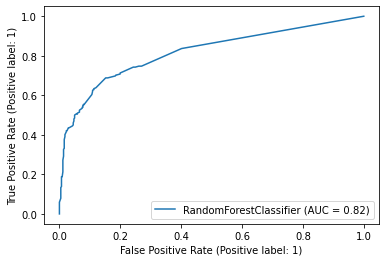

In [ ]:
plot_roc_curve(best_model,features_test,target_test)
plt.show()

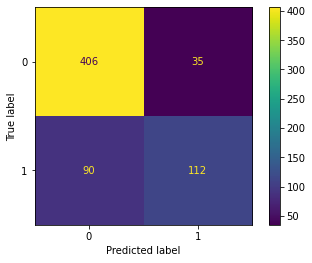

In [ ]:
plot_confusion_matrix(best_model,features_test,target_test)
plt.show()

**Вывод:**

Из Матрицы ошибок может посчитать хрестоматийные метрики:

1) **Recall** = TP / (TP + FN) => 112 / (90 + 112) => 112 / 202 ~ 0.55

2) **Precision** = TP / (TP + FP) => 112 / (112 + 35) => 112 / 147 ~ 0.76